In [27]:
!pip install fuzzywuzzy


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [28]:
!python --version

Python 3.9.13


In [29]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from knn_recommender import Recommender
import numpy as np

In [31]:
song_data = pd.read_csv('10000.txt', sep='\t', header=None, error_bad_lines=False)
song_data.columns = ['user_id', 'song_id', 'listen_count']

song_data_actual = pd.read_csv('song_data.csv', error_bad_lines=False)
song_data_actual.drop_duplicates(['song_id'], inplace=True)

# Merge the two dataframes to create the input dataframe for recommender systems
songs_df = pd.merge(song_data, song_data_actual, on="song_id", how="left")

# Additional step to handle missing values or duplicates if any
songs_df.dropna(inplace=True)  # Drop rows with missing values
songs_df.drop_duplicates(inplace=True)  # Drop duplicate rows

In [32]:
print("First few rows of the 'songs' dataframe:")
songs_df.head()

First few rows of the 'songs' dataframe:


,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [33]:
# Save the dataframe to a CSV file
songs_df.to_csv('songs.csv', index=False)

# Read the saved CSV file into a new dataframe
songsDF = pd.read_csv('songs.csv')

# Display the first few rows of the new dataframe
print("\nFirst few rows of the 'df_songs' dataframe:")
songsDF.head()


First few rows of the 'df_songs' dataframe:


,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


In [34]:
print(f"There are {songsDF.shape[0]} observations in the dataset")

# Check for missing values in the dataframe
songsDF.isnull().sum()

There are 2000000 observations in the dataset


user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

In [35]:
songsDF.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

In [36]:
# Calculate the number of unique songs in the dataset
unique_songs = songsDF['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

# Calculate the number of unique artists in the dataset
unique_artists = songsDF['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

# Calculate the number of unique users in the dataset
unique_users = songsDF['user_id'].unique().shape[0]
# Calculate the number of unique songs in the datasetprint(f"There are {unique_users} unique users in the dataset")

There are 9567 unique songs in the dataset
There are 3375 unique artists in the dataset


In [37]:
pop_songs_top_ten = songsDF.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending=[0, 1])
pop_songs_top_ten['percentage'] = round(pop_songs_top_ten['listen_count'].div(pop_songs_top_ten['listen_count'].sum()) * 100, 2)
pop_songs_top_ten = pop_songs_top_ten[:10]

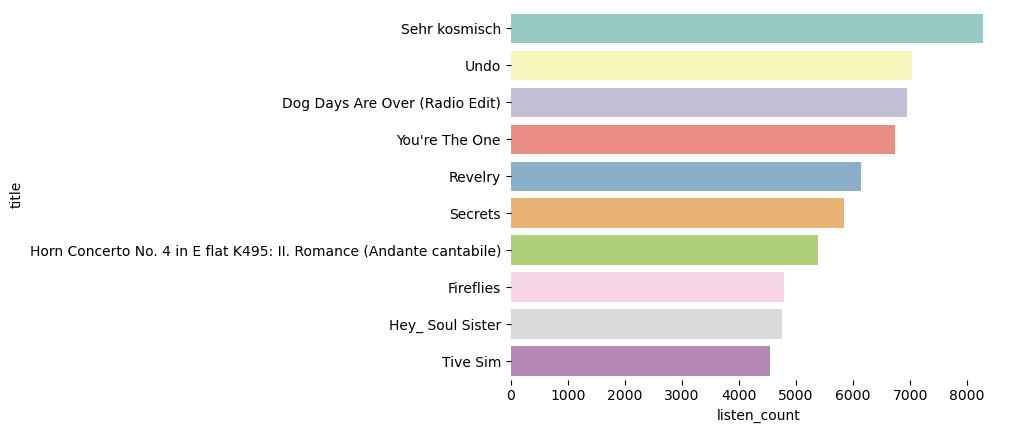

In [38]:
plt.figure()
sns.barplot(x=pop_songs_top_ten['listen_count'], y=pop_songs_top_ten['title'], palette='Set3')
sns.despine(left=True, bottom=True)

In [39]:
pop_artists_top_ten = songsDF.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], ascending=[0, 1])
pop_artists_top_ten = pop_artists_top_ten[:10]

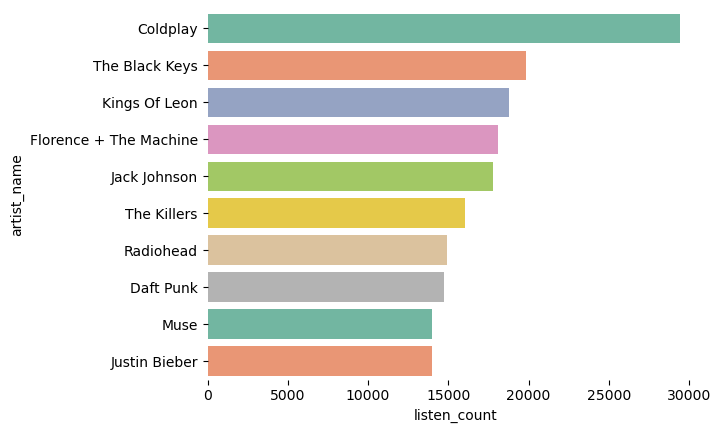

In [40]:
# Create a bar plot for the ten most popular artists
plt.figure()
sns.barplot(x=pop_artists_top_ten['listen_count'], y=pop_artists_top_ten['artist_name'], palette='Set2')
sns.despine(left=True, bottom=True)

In [41]:
listen_counts_df = pd.DataFrame(songsDF.groupby('listen_count').size(), columns=['count'])

max_listen_count = listen_counts_df.reset_index(drop=False)['listen_count'].iloc[-1]
print(f"The maximum time the same user listened to the same songs was: {max_listen_count}")

average_listen_count = songsDF['listen_count'].mean()
print(f"On average, a user listens to the same song {average_listen_count} times")

The maximum time the same user listened to the same songs was: 2213
On average, a user listens to the same song 3.0454845 times


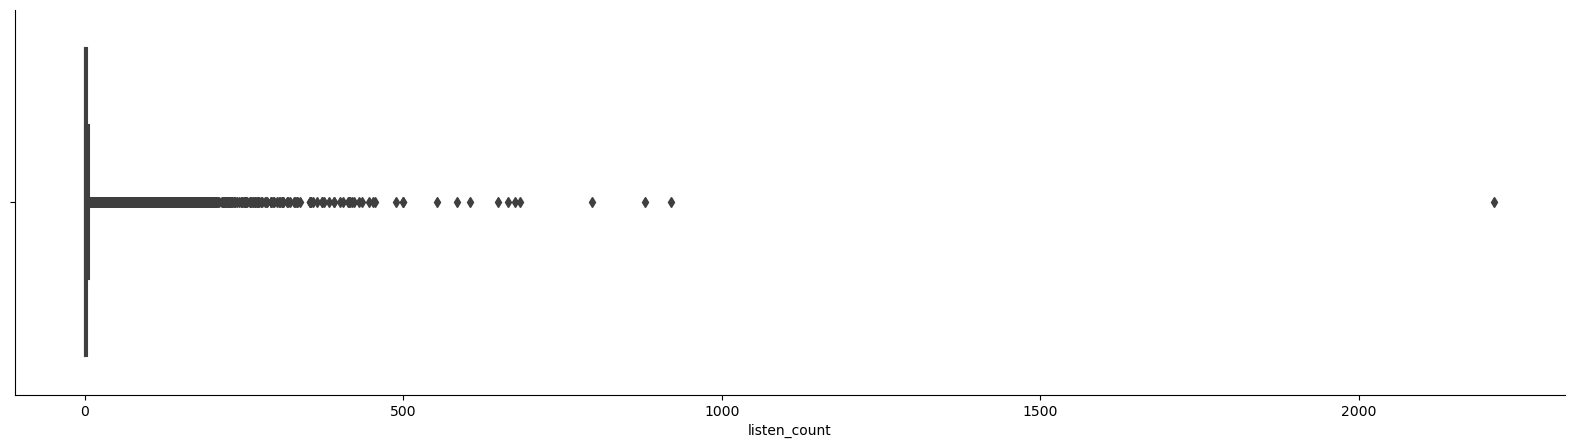

In [42]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='listen_count', data=songsDF)
sns.despine()

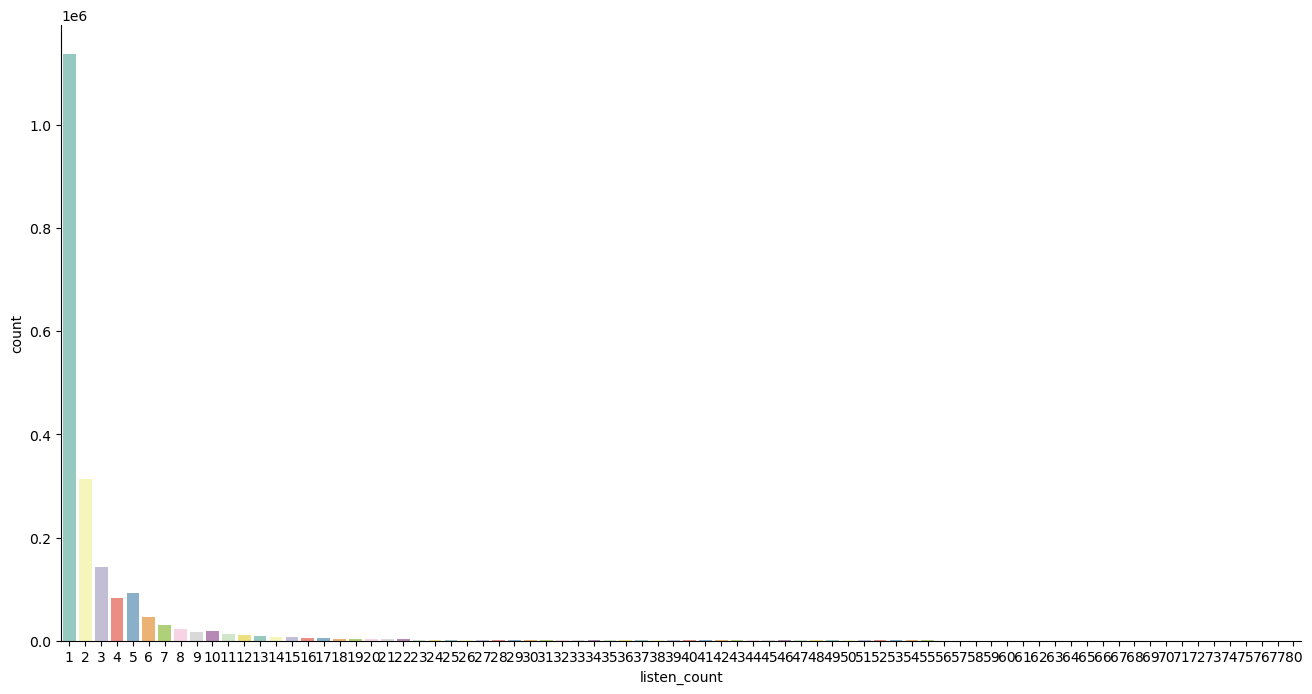

In [43]:
filtered_listen_counts = listen_counts_df[listen_counts_df['count'] > 50].reset_index(drop=False)

# Create a bar plot for filtered listen counts
plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=filtered_listen_counts)
sns.despine(top=True, right=True)
plt.show()

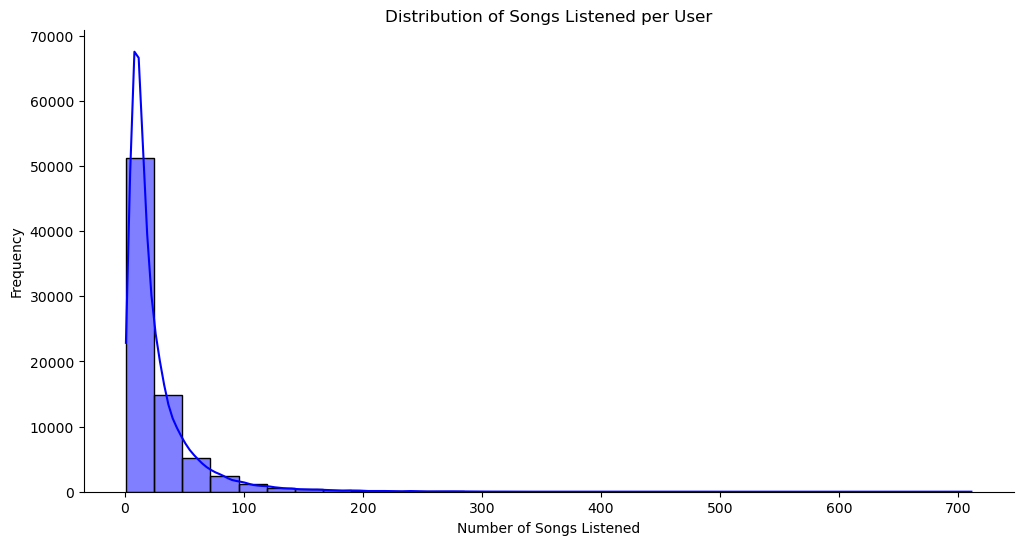

In [44]:
user_song_counts = songsDF.groupby('user_id')['song_id'].count()

plt.figure(figsize=(12, 6))
sns.histplot(user_song_counts.values, color='blue', bins=30, kde=True)
sns.despine(top=True, right=True)
plt.title('Distribution of Songs Listened per User')
plt.xlabel('Number of Songs Listened')
plt.ylabel('Frequency')
plt.show()

In [45]:
# Display statistics about the number of songs listened by a user
print(f"A user listens to an average of {np.mean(user_song_counts)} songs")
print(f"A user listens to an average of {np.median(user_song_counts)} songs, with a minimum of {np.min(user_song_counts)} and a maximum of {np.max(user_song_counts)} songs")

# Matrix information
total_matrix_values = unique_users * unique_songs
zero_values_matrix = total_matrix_values - songsDF.shape[0]
print(f"The matrix of users x songs has {zero_values_matrix} values that are zero")

A user listens to an average of 26.194124657839247 songs
A user listens to an average of 16.0 songs, with a minimum of 1 and a maximum of 711 songs
The matrix of users x songs has 728469151 values that are zero


In [46]:
# Filter users with more than 16 listened songs
active_users = user_song_counts[user_song_counts > 16].index.to_list()

# Filtered dataset
active_users_songs_df = songsDF[songsDF['user_id'].isin(active_users)].reset_index(drop=True)

# Convert the dataframe to a pivot table
songs_listen_matrix = active_users_songs_df.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

In [47]:
# Create a sparse matrix
sparse_listen_matrix = csr_matrix(songs_listen_matrix.values)

songs_listen_matrix.head()

user_id,000e2c2a8c7870ff9121f212b35c8b3a20cc0e67,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,0012bf75d43a724f62dc746d9e85ae0088a3a1d6,001322829b5dc3edc59bf78189617ddd8f23c82a,00185e316f07f0f00c325ca034be59c15b362401,0019740e3e8c24e223a6f88e3faa7c144ec5a014,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,0021d9a4628624f6d70237f9c200ab82e766bf26,...,fff300cd094fe04030b79fae550dc9d065190182,fff4676dacb2e9a7217702f62ee70e88aa512ecc,fff4e1a7dacbe9c13051c08f09bf66d76cbee35e,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffb701ee87a32eff67eb040ed59146121f01571,fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c,fffce9c1537fbc350ea68823d956eaa8f5236dbe,fffd9635b33f412de8ed02e44e6564e3644cf3c6,fffea3d509760c984e7d40789804c0e5e289cc86
song_id,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACSG12AB018DC80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAEJI12AB0188AB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
unique_songs_df = songsDF[['song_id', 'title']].drop_duplicates().reset_index(drop=True)

In [49]:
decode_id = {
    song: i for i, song in
    enumerate(list(unique_songs_df.set_index('song_id').loc[songs_listen_matrix.index].title))
}

In [50]:
# Create and train the recommender model
recommender_model = Recommender(metric='cosine', algorithm='brute', k=20, data=sparse_listen_matrix, decode_id_song=decode_id)

# Specify the new song for which you want recommendations
song_title = 'FireFlies'

# Get recommendations for the specified song
recommendations = recommender_model.make_recommendation(new_song=song_title, n_recommendations=15)

# Display the recommendations
print(f"The Song Recommendations for {song_title} are:")
print(f"{recommendations}")


Starting the recommendation process for FireFlies ...
... Done
The Song Recommendations for FireFlies are:
['Pursuit Of Happiness (nightmare)', 'Marry Me', 'Clocks', 'Drop The World', "Livin' On A Prayer", 'Supermassive Black Hole (Twilight Soundtrack Version)', 'If I Had You', 'Heartbreak Warfare', 'Billionaire [feat. Bruno Mars]  (Explicit Album Version)', 'Dog Days Are Over (Radio Edit)', 'Secrets', 'OMG', 'Vanilla Twilight', 'Sehr kosmisch', 'Hey_ Soul Sister']


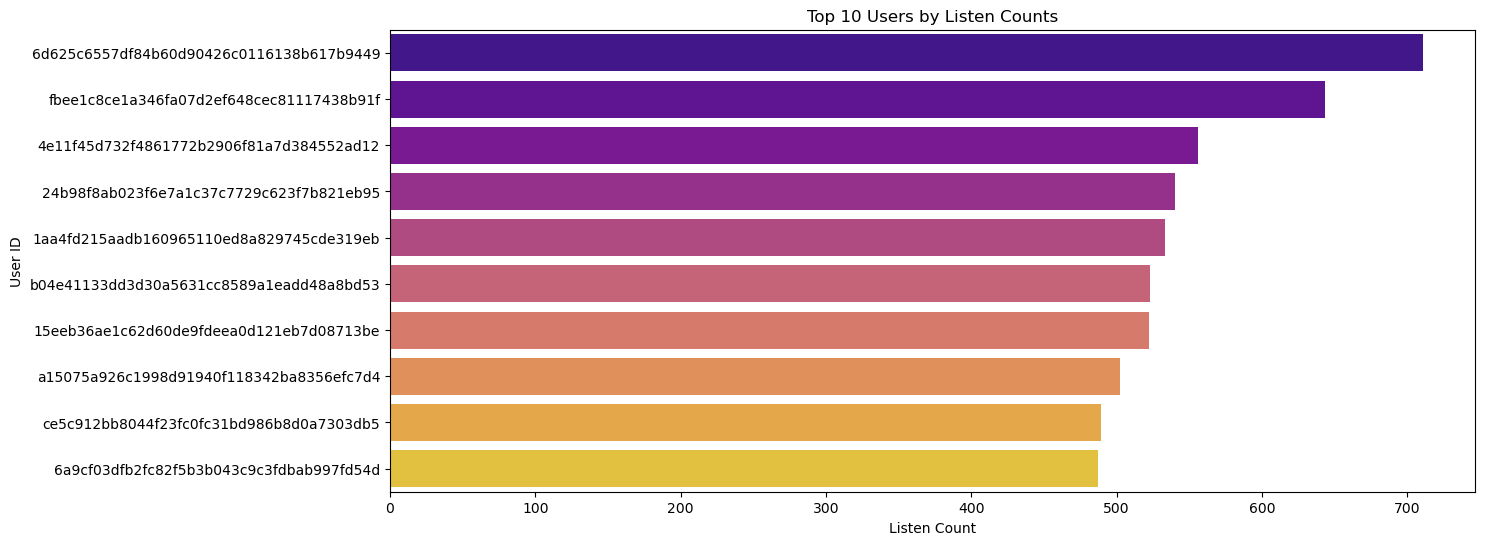

user_id
6d625c6557df84b60d90426c0116138b617b9449    711
fbee1c8ce1a346fa07d2ef648cec81117438b91f    643
4e11f45d732f4861772b2906f81a7d384552ad12    556
24b98f8ab023f6e7a1c37c7729c623f7b821eb95    540
1aa4fd215aadb160965110ed8a829745cde319eb    533
b04e41133dd3d30a5631cc8589a1eadd48a8bd53    523
15eeb36ae1c62d60de9fdeea0d121eb7d08713be    522
a15075a926c1998d91940f118342ba8356efc7d4    502
ce5c912bb8044f23fc0fc31bd986b8d0a7303db5    489
6a9cf03dfb2fc82f5b3b043c9c3fdbab997fd54d    487
Name: song_id, dtype: int64

In [51]:
plt.figure(figsize=(14, 6))
top_users = user_song_counts.sort_values(ascending=False)[:10]
sns.barplot(x=top_users.values, y=top_users.index, palette='plasma', orient='h')  # Use orient='h' for horizontal bars
plt.title('Top 10 Users by Listen Counts')
plt.xlabel('Listen Count')
plt.ylabel('User ID')
plt.show()
top_users